In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ejercicio 1 - Descarga y exploración del corpus


He escogido el dataset de reviews de Amazon de productos de oficin ya que considero que puede ser interesante y tiene una buena cantidad de datos.

### Importamos librerías necesarias

In [ ]:
!pip install stop_words
!pip install wordcloud
!pip install nltk
!pip install gensim
!pip install sklearn_crfsuite


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gzip
import os
import io
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado

# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Cargamos el dataset correspondiente
El fichero que contiene todas las reseñas, es un fichero JSON dentro de una aarpeta ZIP. Por ello, antes de nada, descomprimeremos la carpeta para poder obtener el fichero.

In [ ]:
!unzip -o "/content/drive/MyDrive/NLP/Office_Products_5.zip" -d "/content/drive/MyDrive/NLP/Office_Products_5/"

Archive:  /content/drive/MyDrive/NLP/Office_Products_5.zip
  inflating: /content/drive/MyDrive/NLP/Office_Products_5/Office_Products_5.json  


In [ ]:
dataset_path = '/content/drive/MyDrive/NLP/Office_Products_5/Office_Products_5.json'


In [ ]:
data = pd.read_json(dataset_path, lines=True)

data.head()

reviewerID        asin         reviewerName helpful  \
0  A32T2H8150OJLU  B00000JBLH                  ARH  [3, 4]   
1  A3MAFS04ZABRGO  B00000JBLH     Let it Be "Alan"  [7, 9]   
2  A1F1A0QQP2XVH5  B00000JBLH               Mark B  [3, 3]   
3   A49R5DBXXQDE5  B00000JBLH         R. D Johnson  [7, 8]   
4  A2XRMQA6PJ5ZJ8  B00000JBLH  Roger J. Buffington  [0, 0]   

                                          reviewText  overall  \
0  I bought my first HP12C in about 1984 or so, a...        5   
1  WHY THIS BELATED REVIEW? I feel very obliged t...        5   
2  I have an HP 48GX that has been kicking for mo...        2   
3  I've started doing more finance stuff recently...        5   
4  For simple calculations and discounted cash fl...        5   

                                             summary  unixReviewTime  \
0            A solid performer, and long time friend      1094169600   
1  Price of GOLD is up, so don't bury the golden ...      1197676800   
2   Good functionality, but not durable like old HPs      1293840000   
3       One of the last of an almost extinct species      1145404800   
4                                     Still the best      1375574400   

    reviewTime  
0   09 3, 2004  
1  12 15, 2007  
2   01 1, 2011  
3  04 19, 2006  
4   08 4, 2013

Observando el JSON, podemos afirmar que la propiedad a estudar es reviewText, que es la que contiene la review de un usuario.

Además, también podemos identificar que hay una propiedad, overall, que será nuestra variable objetivo, ya que clasifica el valor de satisfacción de los clientes.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53258 entries, 0 to 53257
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      53258 non-null  object
 1   asin            53258 non-null  object
 2   reviewerName    52799 non-null  object
 3   helpful         53258 non-null  object
 4   reviewText      53258 non-null  object
 5   overall         53258 non-null  int64 
 6   summary         53258 non-null  object
 7   unixReviewTime  53258 non-null  int64 
 8   reviewTime      53258 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.7+ MB


Gracias a data.info() podemos ver que nuestro dataset tiene 53,258 registros y 9 columnas, principalmente con datos de reseñas de productos de oficina. Destacamos que la mayoría de las columnas están completas, aunque reviewerName tiene algunos valores faltantes.

In [ ]:
data.describe()

overall  unixReviewTime
count  53258.000000    5.325800e+04
mean       4.345957    1.340084e+09
std        0.930250    5.266063e+07
min        1.000000    9.701856e+08
25%        4.000000    1.301702e+09
50%        5.000000    1.351728e+09
75%        5.000000    1.387238e+09
max        5.000000    1.406074e+09

Con describe, podemos anañizar las variables categóricas, que en este caso son overall y unixReviewTime.
En este caso, solo nos interesa la variable overall, que contiene información de satisfacción de las reviews.
Destacamos que la media es de 4.36, lo cual, sabiendo que el rango de overall es de 1 a 5, podemos calificar como una media bastante alta en los productos de oficina.


Puesto que las variables que vamos a utilizar a lo largo de esta práctica son 'overall' y 'reviewText', vamos a analizar si tienen valores nulos o empties. En tal caso, esas filas serán eliminadas puesto que no aportan valor.

In [ ]:
# Check for empty values in 'overall' and 'cleaned_review' columns
empty_sentiment = data['overall'].isnull().sum()
empty_cleaned_review = data['reviewText'].isnull().sum()

print(f"Number of empty values in 'sentiment': {empty_sentiment}")
print(f"Number of empty values in 'reviewText': {empty_cleaned_review}")

#Check for empty strings in 'sentiment' and 'cleaned_review' columns
empty_string_sentiment = (data['overall'] == '').sum()
empty_string_cleaned_review = (data['reviewText'] == '').sum()

print(f"Number of empty strings in 'overall': {empty_string_sentiment}")
print(f"Number of empty strings in 'reviewText': {empty_string_cleaned_review}")


Number of empty values in 'sentiment': 0
Number of empty values in 'reviewText': 0
Number of empty strings in 'overall': 0
Number of empty strings in 'reviewText': 21


Sabemos que hay 53258 filas en el dataset. Ahora, procedemos a eliminar las 21 filas que hemos visto de reviewText que tienen como valor string empty.

In [ ]:
# Eliminamos las filas null
data.dropna(subset=['reviewText'], inplace=True)
data = data[data['reviewText'] != '']

Vemos ahora, que, habiendo eliminado 21 filas de las 53258 que ya había, debería haber 53237 filas.

In [ ]:
print(len(data))

53237


## Cardinalidad vocabulario

A continuación, se va a analizar la cardinalidad del vocabulario, es decir, el número de palabras únicas que aparecen en las reseñas de Amazon para productos de oficina.
Para ello, hacemos uso de la función Counter en la columna reviewText del dataframe.



In [ ]:
wordsCounted = Counter(" ".join(data['reviewText']).split())
print(f'Cardinalidad del vocabulario: {len(wordsCounted)}')

Cardinalidad del vocabulario: 241128


El resultado nos da 241,128 palabras distintas, lo que indica un vocabulario bastante amplio.

Esto sugiere que las reseñas contienen una gran variedad de términos, probablemente con muchas palabras poco frecuentes o variantes de una misma palabra.
Podemos, además, mostrar el listado de las palabras más repetidas en las reviews.

In [ ]:
# Palabras más comunes y sus frecuencias
print(wordsCounted.most_common())

[('the', 344994), ('to', 217661), ('a', 209166), ('and', 203097), ('I', 180722), ('is', 131829), ('of', 126943), ('it', 108113), ('for', 98730), ('that', 82730), ('in', 75479), ('you', 71107), ('this', 68022), ('with', 66173), ('on', 65624), ('are', 58105), ('have', 56625), ('my', 53119), ('The', 47947), ('but', 47190), ('not', 44072), ('as', 43729), ('be', 40111), ('or', 37630), ('was', 35000), ('can', 33737), ('so', 33080), ('use', 29130), ('they', 26326), ('like', 25787), ('one', 25689), ('very', 25498), ('It', 25325), ('at', 24593), ('up', 23816), ('from', 23377), ('these', 23237), ('will', 22710), ('if', 22620), ('printer', 22433), ('just', 22315), ('This', 21775), ('an', 21362), ('than', 21320), ('your', 21208), ('would', 21124), ('more', 20710), ('when', 20507), ('has', 19717), ('out', 19498), ('them', 19297), ('paper', 18792), ('all', 18309), ('had', 17206), ('which', 16310), ('get', 16168), ('do', 15832), ('about', 15795), ('good', 15581), ('other', 15147), ('easy', 14937), ("

Las palabras más repetidas son, obviamente, the, to, a, and, etc, que son las llamadas stopwords. Por ello, es muy importante más adelante en el preprocesamiento del texto, eliminar estas palabras.


## Distribución de reviews por número de estrellas
Para ver la distribución de reviews por número de estrellas (overall)

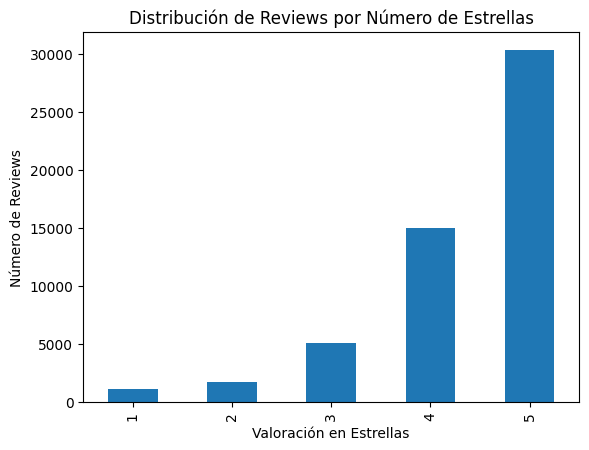

In [ ]:
data['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Valoración en Estrellas')
plt.ylabel('Número de Reviews')
plt.show()

Como conclusión de la distribución de reviews por el número de estrellas, podemos decir que, 5 es el número de estrellas que más se repite, seguido de 4, por lo que podemos decir que la mayoría de estos productos son valorados con las puntuaciones más altas.

## Número de reviews positivas y negativas
Para valorar una review positiva o negativa, las hemos clasificado en positivas y negativas según su calificación: más de 3 estrellas es positiva, y 3 o menos es negativa.



In [ ]:

data['sentiment'] = data['overall'].apply(lambda x: 'positive' if x > 3 else 'negative')
print(data['sentiment'].value_counts())

sentiment
positive    45326
negative     7911
Name: count, dtype: int64


El resultado muestra una clara mayoría de reseñas positivas (45342) frente a las negativas (7916). Esto sugiere que la mayoría de los usuarios dejaron buenas valoraciones.

A continuación, voy a representar en un gráfico de barras la distribución de las reviews en positivas y negativas. Para ello, voy a añadir una columna nueva al dataframe con esta clasificación para poder representarlo.

In [ ]:
data['positivity'] = [ 0 if s <3 else 1 for s in data['overall']]

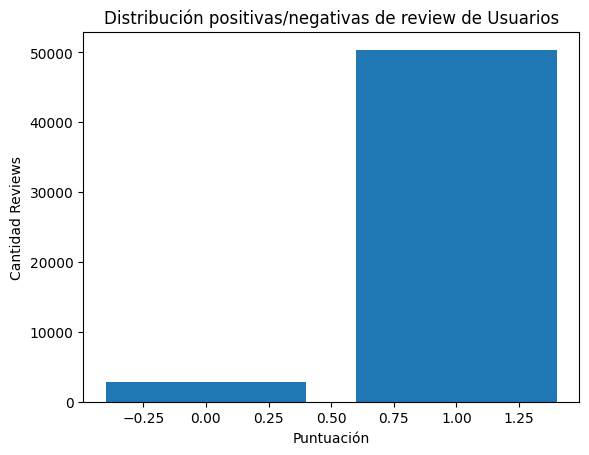

In [ ]:
# Contar las puntuaciones y crear un gráfico de barras
puntuacion_counts = data['positivity'].value_counts()

plt.bar(puntuacion_counts.index, puntuacion_counts.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad Reviews')
plt.title('Distribución positivas/negativas de review de Usuarios')
plt.show()

En el gráfico anterior podemos observar esta gran diferencia mencionada entre las reseñas positivas y negativas, destacando la gran cantidad de reseñas que hemos considerado positivas.

## N-grams más frecuentes


Para ver los n-gramas más frecuentes, considero que sería útil obtener aquellos con 1, 2 o 3 palabras consecutivas, por lo que seleccionaríamos aquellos pertenecientes al rango 1-3.

*   Monogramas más frecuentes:



In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('the', 408898), ('to', 222422), ('and', 211852), ('it', 181899), ('is', 134510), ('of', 128706), ('for', 105822), ('this', 97307), ('that', 93726), ('you', 89947)]


*  Digramas más frecuentes:



In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('of the', 30610), ('on the', 23864), ('it is', 19487), ('in the', 19231), ('if you', 19116), ('this is', 17038), ('and the', 15543), ('you can', 14612), ('to the', 14087), ('to be', 12890)]


*  Trigramas más frecuentes:

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('easy to use', 2895), ('if you are', 2762), ('all in one', 2235), ('if you re', 2198), ('you have to', 2178), ('as well as', 2161), ('out of the', 2067), ('you want to', 2014), ('if you have', 1990), ('one of the', 1938)]


Y como me pica la curiosidad, vamos a ver cuántas veces se repiten los cuatrigramas más frecuentes:

In [ ]:
vectorizer = CountVectorizer(ngram_range=(4, 4))
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('if you want to', 971), ('to be able to', 823), ('out of the box', 822), ('easy to use and', 793), ('easy to set up', 769), ('the quality of the', 668), ('the back of the', 665), ('the top of the', 606), ('you don have to', 598), ('you are looking for', 577)]


Podemos observar que todos los n-gramas anteriores, o la inmensa mayoría, están formados por stopwords del inglés. Por ello, es muy importante eliminar estas palabras para el análisis de sentimiento con el modelo que aplicaremos en el ejercicio 3.
Teniendo esto en cuenta, vamos a obtener los n-gramas de las reviews eliminando estos stopwords, lo cual se puede hacer simplemente usando stop_words='english' como parámetro de la función CountVectorizer, ya que este maneja automáticamente este conjunto de palabras.

*   Monogramas más frecuentes:



In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:20]) #Mostramos los 20 monogramas que más aparecen

[('use', 38178), ('printer', 33843), ('like', 28356), ('paper', 27565), ('just', 24589), ('great', 20461), ('good', 20167), ('easy', 18572), ('ink', 18374), ('tape', 16203), ('print', 15929), ('time', 15536), ('used', 15374), ('don', 15370), ('really', 14747), ('need', 14552), ('quality', 14234), ('labels', 13923), ('product', 13668), ('work', 13593)]


*  Digramas más frecuentes:



In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('easy use', 3044), ('ve used', 2311), ('ink cartridges', 2140), ('dry erase', 2080), ('home office', 1870), ('highly recommend', 1676), ('heavy duty', 1564), ('high quality', 1527), ('print quality', 1495), ('laser printer', 1479)]


*  Trigramas más frecuentes:

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('dry erase board', 630), ('dry erase markers', 517), ('dry erase marker', 295), ('double sided printing', 247), ('office supply store', 218), ('does good job', 217), ('amazon vine program', 205), ('ink jet printer', 205), ('return address labels', 204), ('gel wrist rest', 202)]


A continuación, analizamos las palabras más usadas en cada uno de los conjuntos:
*   Palabras más usadas (monogramas): En las reseñas, las palabras más comunes son
"use", "printer", "one", "like", "paper" y similares. Esto indica que muchas personas hablan sobre impresoras, papel y el uso en general.

*   Frases de dos palabras (digramas): Las combinaciones más frecuentes incluyen "easy use", "ink cartridges", "works well". Esto sugiere que la facilidad de uso y los cartuchos de tinta son temas recurrentes.

*   Frases de tres palabras (trigramas): Aquí destacan frases como "dry erase board", "dry erase markers", "does good job". Parece que la gente menciona la durabilidad de los productos y recomienda ciertos artículos.

En resumen, los comentarios giran mucho en torno a la facilidad de uso, la calidad de los productos (especialmente impresoras, tinta y marcadores de borrado en seco) y la satisfacción con su funcionamiento.

## Nubes de palabras
A cotninuación, se van a representar las reviews en una nube de palabras.
Primero sin stopwords, y luego con ellas, para ver la gran diferencia en el resultado.

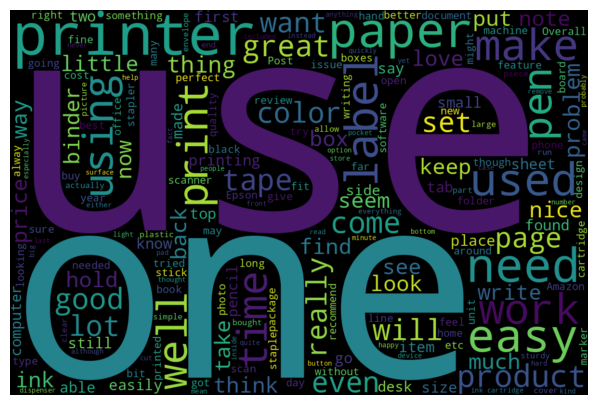

In [ ]:
wordcloud = WordCloud(width=1200, height=800).generate(" ".join(data['reviewText']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

En el gráfico anterior podemos ver las palabras más repetidas y que más aparecen en las reviews de los productos de oficina de Amazon. La función WordCloud de Python filtra por defecto las palabras vacías o stopwords comunes en inglés, como son "the", "and", "is", etc, por eso ninguna de estas palabras aparecen representadas, a pesar de ser las más comunes.

Si queremos que las stopwords aparezcan, se puede añadir el parámetro en la función. A pesar de que esto no es útil, pùesto que las stopwords no aportan información, con el siguiente código podemos representarlas:

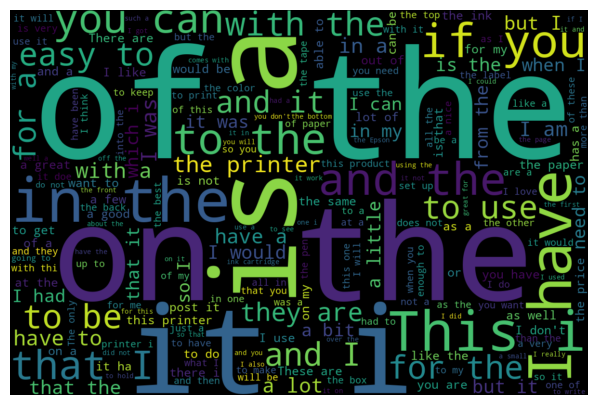

In [ ]:
stopwords = set()

wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords).generate(" ".join(data['reviewText']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec

Para utilizar Word2Vec, se va a primero a seleccionar 5 palabras de las más repetidas de las reviews:

In [ ]:
# Seleccionamos 5 palabras muy repetidas repetidas
most_common_words= ['printer','paper','good','easy','quality']

A continuación, se preparan las oraciones y el modelo Word2Vec.
Para ello, se dividen las reseñas en oraciones y se entrena el modelo Word2Vec con estas oraciones y se obtienen las 10 palabras más similares a cada una de las 5 palabras comunes.

In [ ]:
sentences = [review.split() for review in data['reviewText'].dropna()]
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
similar_words = {word: [item[0] for item in model.wv.most_similar(word, topn=10)] for word in most_common_words}

Con el siguiente código se preparan los vectores de las palabras creando una lista con todas las palabras, tando las comunes como sus similares, y se obtienen los vectores de las palbras. Además, se aplica PCA para reducir la dimensionalidad de los vectores a dos componentes.

In [ ]:
all_words = sum([[k] + v for k, v in similar_words.items()], [])
word_vectors = np.array([model.wv[word] for word in all_words])
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

Por último, se va a crear una figura para la visualización:

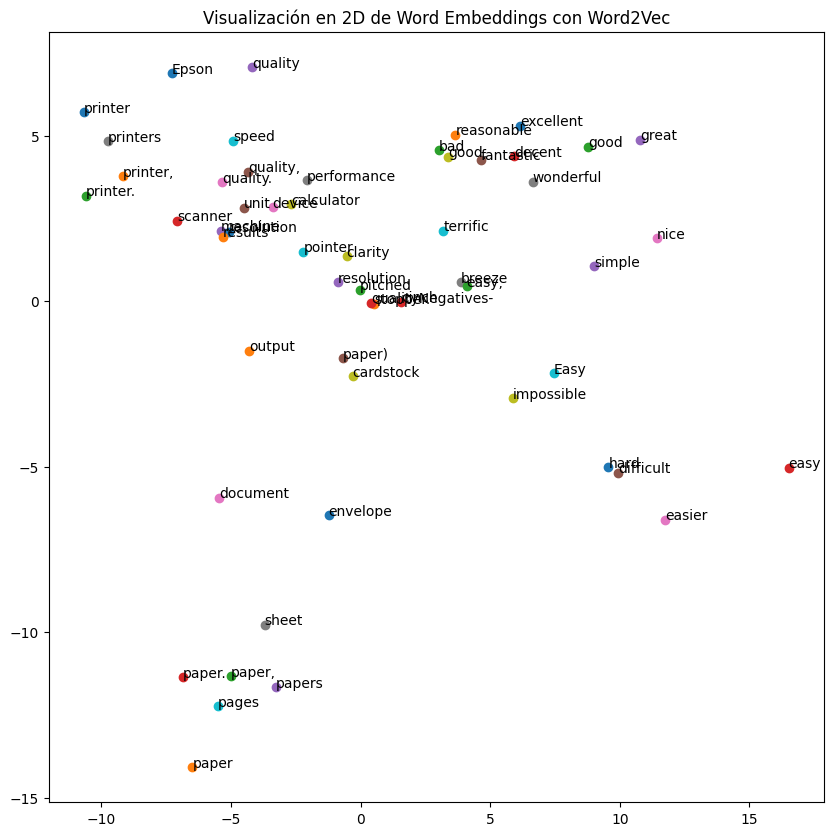

In [ ]:
plt.figure(figsize=(10,10))
for i, word in enumerate(all_words):
    plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1])
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))
plt.title('Visualización en 2D de Word Embeddings con Word2Vec')
plt.show()

En el gráfico anterior, podemos ver que aparecen las cinco palabras muy repetidas que hemos seleccionado ('printer','paper','good','easy','quality'), y palabras similares a cada una de ellas.

POdemos ver las siguientes similitudes para estas palabras:
*  La palabra "printer" está asociada con palabras como "Epson","printers", "quality", "speed", "performance", "scanner", "machine", "resolution", "output" y "clarity". Esto sugiere que las conversaciones sobre impresoras a menudo incluyen estas características y equipos relacionados.

*  La palabra "paper" está rodeada por términos como "papers", "sheets", "sheet", "document", "pouch" y "cardstock". Esto indica que "paper" está asociado a menudo con documentos, hojas y materiales relacionados.

*  La palabra "good" está cerca del centro del gráfico y se asocia con términos positivos como "great", "excellent", "wonderful", "fantastic", "nice", "simple" y "convenient". Esto sugiere que "good" está relacionado con adjetivos positivos y términos que describen cualidades favorables.

*  La palabra "easy" está en el cuadrante izquierdo del gráfico y está asociada con palabras como "easier", "Easy", "convenient", "simple", "nice", "great" y "good". Esto sugiere que "easy" está relacionado con términos que describen simplicidad y conveniencia.

*  La palabra "quality" está en el cuadrante superior derecho y se asocia con términos como "performance", "clarity", "resolution", "speed", "output" y "printer". Esto indica que esta palabra está relacionado con características que describen el rendimientode estos productos de oficina.


## Conclusiones de la exploración


Las conclusiones que puedo sacar del proceso de exploración son las siguientes:
*  Las reseñas son mayormente positivas: La mayoría tienen más de 3 estrellas, lo que indica que a la gente le gustan estos productos.

*  Mucho vocabulario: Hay más de 240,000 palabras únicas en el dataset, lo que muestra una gran variedad en cómo la gente describe los productos. Esto significa que limpiar y procesar el texto es clave para obtener buenos resultados en el análisis.

*  Palabras y frases clave: Después de limpiar el texto eliminando stopwords, las palabras más comunes son palabras relacionas con valoraciones con productos de oficina (como era de esperar) ya que dentro de las palabras que más se repiten encontramos "printer", "paper", "use", "quality", o "easy". Además, los n-gramas resaltan temas como la facilidad de uso, la calidad de impresión y los consumibles como los cartuchos de tinta.

*  Análisis con Word2Vec: El modelo de embeddings ayuda a visualizar relaciones entre palabras. Por ejemplo, "printer" se agrupa con términos técnicos, mientras que "good" se asocia con adjetivos positivos, como greate.

*  Se necesita más preprocesamiento: Para mejorar la calidad de los datos y obtener mejores resultados en modelos de aprendizaje automático, es esencial eliminar ruido, lematizar palabras y normalizar el texto.

# Ejercicio 2. Etapa de preprocesado de texto
En este ejercicio se va a llevar a cabo el proceso de las reviews para eliminar sus stopwords, signos de puntuación, etc.

Se va a proceder a limpiar las reviews y, tras su limpieza, añadiremos una nueva columna al dataset tras la limpieza. Para la limpieza de las reviews se van a llevar a cabo los siguientes pasos:
- Convertir a minúsculas y así unificar el texto.
- Eliminar URLs y menciones que hay en algunas reviews.
- Eliminar signos de puntuación como comas y puntos.
- Eliminar caracteres especiales y puntuación.
- Eliminar stopwords en inglés filtrando palabras sin significado relevante. Para ello, primero tokenizamos el texto de ewntrada, es decir, convertimos cada palabra en un token.
- Lematizar para reducir palabras a su forma base.
- Eliminar espacios adicionales para evitar problemas con cadenas vacías.

Para ello, se va a crear una función para cada una de estas acciones a llevar a cabo con las reviews.


In [ ]:

def to_lowercase(text):
    """Convierte el texto a minúsculas."""
    return text.lower()

def remove_urls_mentions(text):
    """Elimina URLs y menciones en el texto."""
    return re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#\w+', '', text, flags=re.MULTILINE)

def remove_punctuation(text):
    """Elimina signos de puntuación del texto reemplzándolos por espacios."""
    return text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

def remove_special_chars(text):
    """Elimina caracteres especiales dejando solo letras y números"""
    return re.sub(r'[^a-z0-9\s]', '', text)

def remove_stopwords(text):
    """Elimina stopwords del Inglés."""
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return ' '.join([word for word in words if word.lower() not in stop_words])

def lemmatize_text(text):
    """Aplica lematización a las palabras."""
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def preprocess_text(text):
    """Realiza el preprocesamiento completo del texto llamando a las funciones creadas anteriormente."""
    if not isinstance(text, str):
        return ""
    text = to_lowercase(text)
    text = remove_urls_mentions(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text


Una vez tenemos definida la función preprocess_text que llama a todas las funciones necesarias para preprocesar las reviews, se va a a crear otra función que crea una nueva columna en el dataframe con las reviews procesadas.

In [ ]:
def preprocess_reviews(data):
    """Aplica el preprocesamiento a todas las reviews del DataFrame."""
    data['cleaned_review'] = data['reviewText'].astype(str).apply(preprocess_text)
    return data

In [ ]:
# Aplicamos el preprocesamiento e imprimimos el resutlado
data = preprocess_reviews(data)
print(data[['reviewText', 'cleaned_review']])

                                              reviewText  \
0      I bought my first HP12C in about 1984 or so, a...   
1      WHY THIS BELATED REVIEW? I feel very obliged t...   
2      I have an HP 48GX that has been kicking for mo...   
3      I've started doing more finance stuff recently...   
4      For simple calculations and discounted cash fl...   
...                                                  ...   
53253  What I like about this scale is you can power ...   
53254  This Accuteck ShipPro digital scale works very...   
53255  I ship a lot of stuff.  I sell small parts, ma...   
53256  This is a great little scale to have. It can w...   
53257  When asked to review this scale, I almost decl...   

                                          cleaned_review  
0      bought first hp12c 1984 served faithfully 2002...  
1      belated review feel obliged share view old wor...  
2      hp 48gx kicking twenty year hp 11 25 year old ...  
3      started finance stuff recently went 

A continuación, vamos a probar si la función preprocess_reviews funciona como esperado, probando con disitintos ejemplos.

In [ ]:
# Test cases para probar las funciones definidas previamente
test_cases = {
    "Convert to lowercase": ("Hello World", "hello world"),
    "Remove URLs and mentions": ("Visit https://example.com and follow me @user #cool", "visit follow"),
    "Remove special characters": ("hello_world! this is a test 123 _*!)(¿?):;&%$·_#@", "hello world test 123"),
    "Tokenization and stopword removal": ("hello world this is a test", "hello world test"),
    "Join words back": ("hello world test", "hello world test"),
    "Lemmatization": ("running flies better", "running fly better"),
}

# Run tests
for test_name, (input_text, expected_value) in test_cases.items():
    result = preprocess_text(input_text)
    print(f"{test_name}: {'✅ PASSED' if result == expected_value else f'❌ FAILED (Got: {result})'}")

Convert to lowercase: ✅ PASSED
Remove URLs and mentions: ✅ PASSED
Remove special characters: ✅ PASSED
Tokenization and stopword removal: ✅ PASSED
Join words back: ✅ PASSED
Lemmatization: ✅ PASSED


# Ejercicio 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

En este ejercicio, se va a entrenar el dataset de reviews con dos modelos de clasificación.

Lo primero de todo es definir el problema de clasificación. Para ello, se ha pensado definir si una reseña expresa sentimiento positivo o negativo, es decir, es positiva o negativa, basándonos en el número de estrellas de la review de los usuarios.

En este caso, puesto que overall representa la calificación del usuario, podemos convertirla en una variable binaria para así tener un problema de clasificación binaria supervisada.
Puesto que tiene un valor del 1 al 5, tendremos en cuenta lo siguiente:
*   Sentimiento positivo (1): Si la calificación es 4 o 5.
*   Sentimiento negativo (0): Si la calificación es 1 o 2 o 3.

Esto nos permitirá realizar una clasificación supervisada en dos clases.


Los modelos que se han seleccionado son: **Regresión Logística** y **Random Forest**.


In [ ]:
def classify_sentiment(df):
    """Convierte la columna 'overall' en una variable binaria para clasificación de sentimientos."""
    df['sentiment'] = np.where(df['overall'] > 3, 1, 0)  # Sentimiento positivo (1) si 4 o 5, negativo (0) si es 1 o 2 o 3
    return df
data = classify_sentiment(data)

In [ ]:
print(data[['cleaned_review', 'overall', 'sentiment']].head())


                                      cleaned_review  overall  sentiment
0  bought first hp12c 1984 served faithfully 2002...        5          1
1  belated review feel obliged share view old wor...        5          1
2  hp 48gx kicking twenty year hp 11 25 year old ...        2          0
3  started finance stuff recently went looking go...        5          1
4  simple calculation discounted cash flow one st...        5          1


## Selección de algoritmos a utilizar
A continuación, se eligen los dos algoritmos que se van a utilizar en este ejercicio de clasificación binaria:

### Regresión Logística
La Regresión Logística es un algoritmo que nos ayuda a tomar decisiones cuando solo hay dos opciones posibles como en este caso, prediciendo si una reseña es positiva (1) o negativa (0).

La Regresión Logística, usa una curva en forma de "S" (función sigmoide) para separar en dos grupos los puntos de un gráfico y convierte cualquier número en un valor entre 0 y 1. Si el valor está más cerca de 1, significa que el modelo cree que pertenece a la categoría positiva, y si está cerca de 0, cree que es negativa.

Se ha decidido usar este algoritmo en este problema de clasificación porque es sencillo y efectivo cuando los datos están bien spearados como en este caso y porque es rápido de entrenar.

### Random Forest
El Random Forest es un algoritmo que toma muchas pequeñas decisiones para llegar a una gran conclusión. En lugar de usar una sola regla para clasificar algo, crea muchos "árboles de decisión" y luego vota por la mejor opción.
Se ha escogido este algoritmo por el manejo de relaciones compejas que tiene, lo cual es bueno para anaalizar las reviews, y por su robustez y gran capacidad de reducir el sobreajuste.




Una vez que se han escogido estos algoritmos, lo primero que hacemos hacer la división del dataset en train y test. Para eso, se escoge que el 75% de los datos sean de train y el 25% restante de test.

In [ ]:
# División en Train y Test
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_review'],
    data['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

# Representación de la longitud de estos cuatro datasets.
print(f"X_train: {len(X_train)} filas")
print(f"X_test: {len(X_test)} filas")
print(f"y_train: {len(y_train)} filas")
print(f"y_test: {len(y_test)} filas")

X_train: 39927 filas
X_test: 13310 filas
y_train: 39927 filas
y_test: 13310 filas


A continuación, se puede, por ejemplo, para el dataset X_train que sus 10 primeras filas son random, ya que al dividir en train y test el orden se pierde. Lo mismo para  el dataset X_test.

In [ ]:

X_train.iloc[:10]

13280    purchased laminate thing classroom work great ...
30758    printer step form workforce 600 love moved ano...
18747    auto feeder even 3 year old use sharpener stic...
33630    stapler great easy load easy use making flyer ...
34236    great job printing big ups shipping label need...
25649    bought replace hp one wireless printer many is...
12095    little baby keep organized clear ton meeting b...
2626     nice looking notebook 100 sheet wide ruled use...
28949    initial impression device underwhelming fact l...
18915    much say filing tab probably care thing 1 last...
Name: cleaned_review, dtype: object

In [ ]:
X_test.iloc[:10]

47657    kind past notebook stage go school longer work...
3662     super tough tape almost make like price object...
34332    bought phone set replace 20 year old roam phon...
52512    welcome addition home office supplement inkjet...
13659    got envelope still pay bill snail mail every m...
48010    good product file folder internal easily acces...
34834    lot problem office chair figured arm swing wou...
5502     perfect sized binder storing assortment paper ...
27438    lot card lot lot scrap booking generally glue ...
22249    much say product fact supposed colorful making...
Name: cleaned_review, dtype: object

Para la **extracción de características**, podemos utilizar distintas técnicas. Yo he planteado dos opciones: TfidfVectorizer y Bag-of-Words (BoW).

*   Bag-of-Words (BoW)
Convierte un conjunto de documentos en una matriz de recuento de palabras. En la matriz, cada fila representa un documento y cada columna una palabra, y su valor indica cuántas veces aparece la palabra en el documento.

*   TfidfVectorizer
Es una herramienta que convierte los textos en vectores numéricos utilizando la métrica TF-IDF (Term Frequency-Inverse Document Frequency). Para ello, asigna un peso a cada palabra basándose en el número de veces que una palabra aparece en un documento, y penalizando las palabras comunes que aparecen en muchos documentos.

En este caso, he escogido utilizar TfidfVectorizer de sklearn. Para usar esta función, se han configurado los siguientes parámetros para optimizar la representación del texto:
*   ngram_range: (1, 3). Para quedarnos con monogramas, digramas y trigramas. Esto permite capturar mejor el contexto y las relaciones entre términos, en lugar de considerar solo palabras aisladas.
*   max_df: 0.95. Se eliminarán términos que aparezcan en más del 95% de los documentos, ya que es probable que sean demasiado comunes y no aporten información útil. Sin embargo, dado que el preprocesamiento previo ya eliminó las stopwords y lematizó los textos, no es necesario un filtrado más agresivo.
*   min_df: 3. Se descartarán los términos que aparezcan en menos de tres reviews, ya que se consideran poco representativos y podrían ser outliers o ruido dentro del corpus de datos.
*   max_features: 2500. Se limitará el tamaño del vocabulario a un máximo de 2500 palabras. Esto asegura que se incluyan los unigramas, bigramas y trigramas más relevantes para el análisis.

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

In [ ]:
print(list(vectorizer.vocabulary_.items())[:20])

[('purchased', 1718), ('laminate', 1172), ('thing', 2246), ('classroom', 406), ('work', 2461), ('great', 961), ('using', 2358), ('scotch', 1903), ('brand', 293), ('laminating', 1174), ('pouch', 1644), ('disappointed', 630), ('printer', 1683), ('step', 2116), ('form', 884), ('workforce', 2465), ('600', 41), ('love', 1271), ('moved', 1395), ('another', 138)]


A continuación, se aplica el vectorizer a los conjuntos de train y test para poder utilizar los conjuntos  vectorizados en los modelos.

In [ ]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Regresión Logística
En este apartado vamos a entrenar el modelo con Regresión Logística.
Primero, vamos a entrenar el modelo con distintos valores para el parámetro C de LogisticRegression y predecimos en Test para obtener el mejor accuracy, quedándonos con el mejor valor de C y poder entrenar el modelo de nuevo con este valor.

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1,1.5,2, 10, 100, 1000, 10000] # Valores de C a probar

train_acc = list()
test_acc = list()
for c in c_params: # Entrenamos el modelo por cada valor de C e imprimimos el accuracy
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_vec, y_train)

    train_predict = lr.predict(X_train_vec)
    test_predict = lr.predict(X_test_vec)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8525169045830203
Accuracy for C=0.05: 0.8525169045830203
Accuracy for C=0.25: 0.862885048835462
Accuracy for C=0.5: 0.8694214876033057
Accuracy for C=1: 0.8730277986476334
Accuracy for C=1.5: 0.8730277986476334
Accuracy for C=2: 0.8742299023290759
Accuracy for C=10: 0.871900826446281
Accuracy for C=100: 0.8693463561232156
Accuracy for C=1000: 0.8679939894815928
Accuracy for C=10000: 0.8681442524417731


In [ ]:
best_C = 2
print(f"El mejor valor para el parámetro C es: {best_C}")

El mejor valor para el parámetro C es: 2


Además, vamos a graficar el accuracy para los distintos valores de C al evaluar el modelo de Regresión Logística:

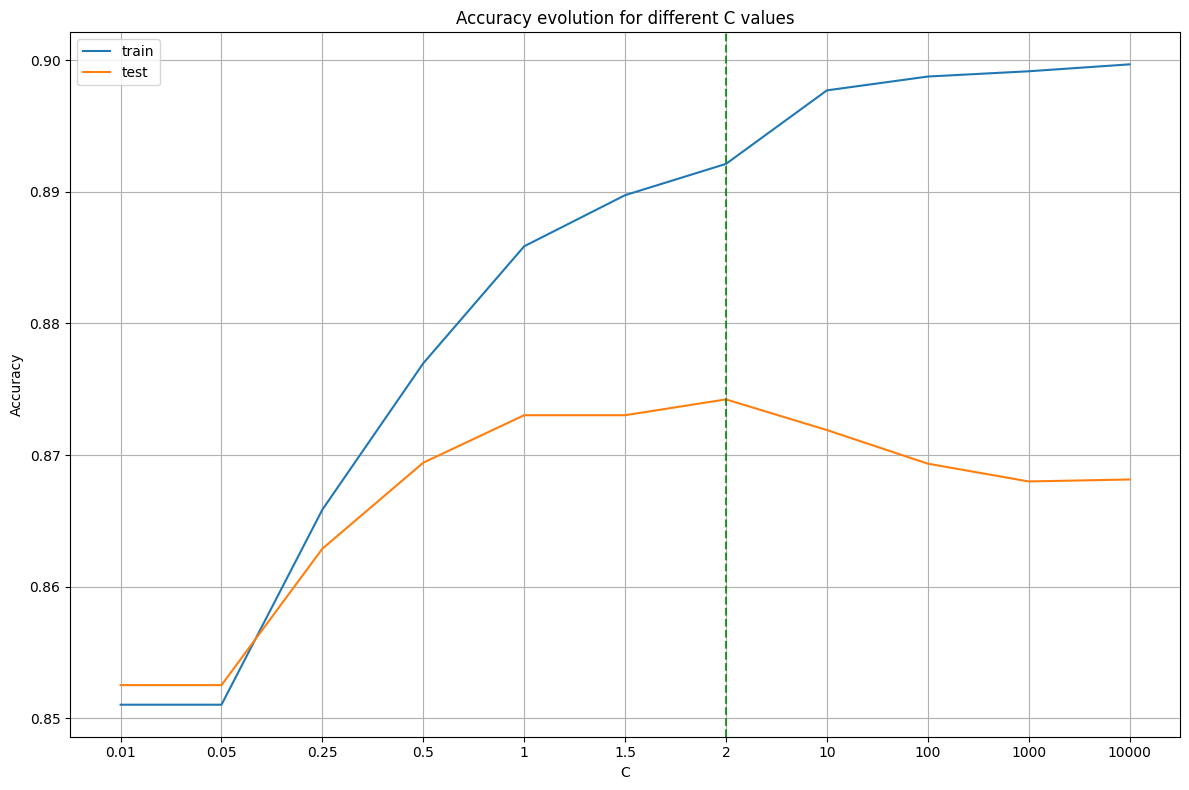

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Impacto de C en la precisión: A medida que el valor de C aumenta, la precisión del modelo en el conjunto de entrenamiento mejora, lo que indica un mejor ajuste a los datos.

Sobreajuste: Para valores altos de C, la precisión del conjunto de entrenamiento sigue aumentando, pero la precisión del conjunto de prueba comienza a disminuir, lo que sugiere sobreajuste. Por ello, el valor óptimo de C es 2, que es la que seleccionamos para entrenar el modelo:

In [ ]:
# Modelo 1: Regresión Logística con mejor C
lr = LogisticRegression(C=best_C, solver='lbfgs', max_iter=500) #Establecemos un límite de 500 iteraciones para la convergencia del algoritmo.
lr.fit(X_train_vec, y_train)

train_predict_rl = lr.predict(X_train_vec)
test_predict_rl = lr.predict(X_test_vec)

## Random Forest

In [ ]:
# Modelo 2: Random Forest
n_estimators = 32

def classifyRandomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    clf.fit(X_train, y_train)

    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))

    return clf

randomForestClassifier = classifyRandomForest(X_train_vec, X_test_vec, y_train, y_test)

[RandomForestClassifier] Accuracy: train = 0.9991484459137927, test = 0.85717505634861


## Selección mejor modelo
Una vez tenemos el dataset entrenado con ambos modelos, vamos a comparar el resultado de ambos.
Primero, vamos a crear una función que calcula las métricas de accuaracy, precisión, recall y F1-score, para después, aplicarla a los resultados de regresión logística y Random Forest.

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, average='weighted'),
        "Recall": recall_score(y_test, y_test_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_test_pred, average='weighted')
    }
    print(classification_report(y_test, y_test_pred))

    return metrics

Y ahora, evaluamos con esta función los distintos resultados.

In [ ]:
# Evaluar Regresión Logística
print(f"\nMétricas de Regresión Logística:")
metrics_lr = evaluate_model(lr, X_train_vec, X_test_vec, y_train, y_test, "Regresión Logística")

print(f"\nMétricas de Random Forest:")
# Evaluar Random Forest
metrics_rf = evaluate_model(randomForestClassifier, X_train_vec, X_test_vec, y_train, y_test, "Random Forest")

# Comparación de resultados
print("\nComparación de métricas:")
comparison = pd.DataFrame([metrics_lr, metrics_rf], index=["Regresión Logística", "Random Forest"])
print(comparison)


Métricas de Regresión Logística:
              precision    recall  f1-score   support

           0       0.67      0.30      0.41      1963
           1       0.89      0.97      0.93     11347

    accuracy                           0.87     13310
   macro avg       0.78      0.63      0.67     13310
weighted avg       0.86      0.87      0.85     13310


Métricas de Random Forest:
              precision    recall  f1-score   support

           0       0.70      0.05      0.10      1963
           1       0.86      1.00      0.92     11347

    accuracy                           0.86     13310
   macro avg       0.78      0.53      0.51     13310
weighted avg       0.84      0.86      0.80     13310


Comparación de métricas:
                     Accuracy  Precision    Recall  F1-score
Regresión Logística  0.874230   0.855941  0.874230  0.852886
Random Forest        0.857175   0.836086  0.857175  0.801305


Teniendo en cuenta las métricas de precisión, recall, f1-score y support, ambos modelos tienen un desempeño bastante bueno. Sin embargo, encontramos algunas diferencias clave:

*  Regresión Logística tiene mejor precisión (0.89 vs. 0.86) y recall en la clase mayoritaria (1), lo que significa que clasifica bien la mayoría de los casos positivos. Sin embargo, su recall en la clase minoritaria (0) es bastante bajo (0.30), lo que indica que no detecta bien las reseñas negativas.
*  Random Forest tiene una precisión un poco menor (0.86 vs. 0.89 en la clase 1), pero logra un recall del 100% en la clase 1, lo que significa que detecta todas las reseñas positivas. Sin embargo, su recall en la clase 0 es extremadamente bajo (0.05), lo que indica que casi no detecta reseñas negativas.

Para saber cuál es mejor, depende un poco del objetivo. Si es más importante detectar todas las reseñas positivas y no nos preocupa tanto identificar correctamente las negativas, Random Forest es mejor. Pero si queremos un modelo más balanceado, Regresión Logística tiene un mejor rendimiento general, ya que al menos capta un 30% de las reseñas negativas y tiene métricas más equilibradas. A mi parecer, considero que es mejor un modelo un poco más balanceado, por lo que selecciono Regresión Logística como el mejor entre ambos.

# Ejercicio 4. Reporte de métricas y conclusiones
Puesto que el mejor algoritmo para detectar la clase positiva como la negativa (aunque esta bastante peor) es la Regresión Logística, se van a obtener distintas métricas de este algoritmo para conocer su bondad. La bondad del modelo se refiere a qué tan bien el modelo realiza sus predicciones, es decir, es una forma de evaluar su rendimiento y utilidad.

Primero, vamos a crear una función que genere la matriz de confusión para el modelo de Regresión Logística.


In [ ]:
def confussionMatrix(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    return metrics


Matriz de confusión de Regresión Logística:


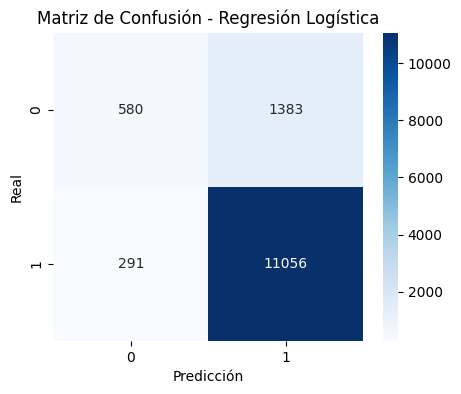

<module 'sklearn_crfsuite.metrics' from '/usr/local/lib/python3.11/dist-packages/sklearn_crfsuite/metrics.py'>

In [ ]:
# Evaluar Regresión Logística
print(f"\nMatriz de confusión de Regresión Logística:")
confussionMatrix(lr, X_train_vec, X_test_vec, y_train, y_test, "Regresión Logística")

Los conclusiones que se observan de esta matriz son las siguientes:
*  Precisión alta en la clase 1:
De 11,347 casos reales de la clase 1, el modelo predijo correctamente 11,056.
Solo 291 fueron clasificados erróneamente como 0.
Esto indica que el modelo es bueno identificando reseñas positivas.

*  Problemas con la clase 0:
De 1,963 casos reales de la clase 0, solo 580 fueron correctamente clasificados.
1,383 fueron mal clasificados como 1, lo que sugiere que el modelo tiene dificultades para identificar reseñas negativas.

*  Modelo sesgado hacia la clase mayoritaria:
Como hay muchas más reseñas positivas que negativas en el dataset como vimos, el modelo favorece la clase 1.
Esto puede explicarse por el desbalance en los datos, lo que afecta la capacidad del modelo para reconocer correctamente la clase minoritaria.


A continuación, he considerado oportuno graficar los siguientes datos para continuar evaluado la bondad:
*  Curva ROC y AUC: Si el AUC está cerca de 1, el modelo es bueno. Si está cerca de 0.5, es casi aleatorio.
*  Curva de Precisión-Recall: Útil si las clases están desbalanceadas. Una curva más alta indica mejor rendimiento.
*  Distribución de Probabilidades: Si el modelo predice con confianza (valores cercanos a 0 o 1), significa que separa bien las clases. Si hay muchas predicciones en 0.5, el modelo tiene incertidumbre.

Para ello, tenemos la ssiguientes funciones:

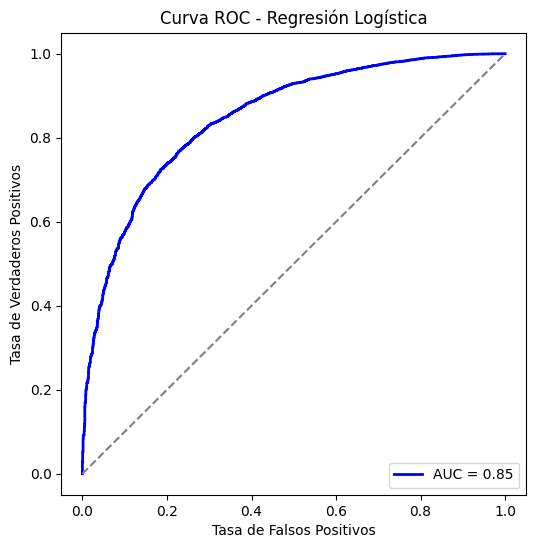

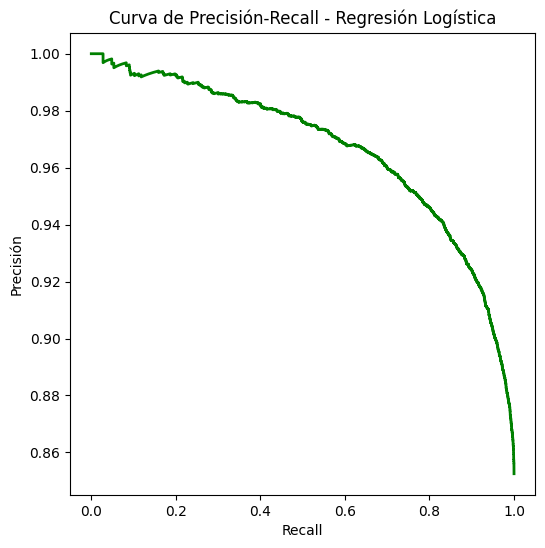

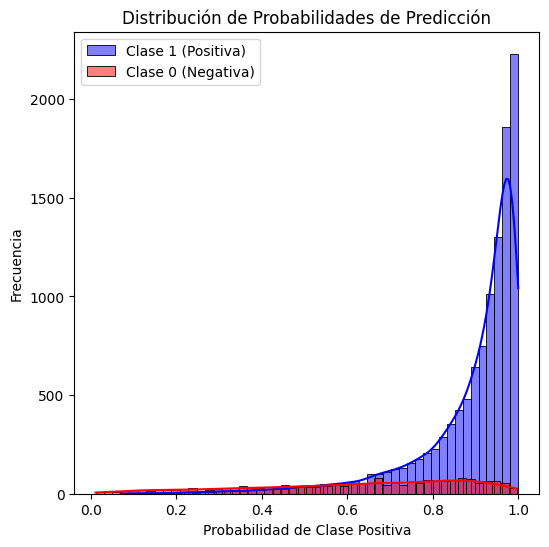

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Obtener probabilidades de predicción
y_probs = lr.predict_proba(X_test_vec)[:, 1]

# --- 1. Curva ROC y AUC ---
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

#Representación gráfica
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.show()

# --- 2. Curva de Precisión-Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_probs)

#Representación gráfica
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva de Precisión-Recall - Regresión Logística")
plt.show()

# --- 3. Distribución de Probabilidades de Predicción ---
plt.figure(figsize=(6, 6))
sns.histplot(y_probs[y_test == 1], bins=50, color="blue", label="Clase 1 (Positiva)", kde=True)
sns.histplot(y_probs[y_test == 0], bins=50, color="red", label="Clase 0 (Negativa)", kde=True)
plt.xlabel("Probabilidad de Clase Positiva")
plt.ylabel("Frecuencia")
plt.title("Distribución de Probabilidades de Predicción")
plt.legend()
plt.show()


A continuación, muestro mis conclusiones basadas en los gráficos obtenidos:

*  Curva ROC y AUC:
La curva ROC muestra el desempeño del modelo en términos de la tasa de verdaderos positivos frente a la tasa de falsos positivos.
El valor del AUC (Área Bajo la Curva) es de aproximadamente 0.85, lo que indica un buen desempeño del modelo, ya que como he mencionado, un AUC cercano a 1 indica un modelo excelente, mientras que un valor de 0.5 sugiere que el modelo no tiene capacidad predictiva.
En este caso, 0.85 sugiere que el modelo tiene una capacidad de discriminación bastante buena.

*  Curva de Precisión-Recall:
La curva de precisión-recall es útil cuando hay un desequilibrio en las clases, como es el caso.
La curva muestra que el modelo mantiene una alta precisión para valores de recall elevados, aunque la precisión comienza a caer a medida que el recall aumenta.
Esto indica que el modelo maneja bien los falsos positivos y logra buenas predicciones de la clase positiva.

*  Distribución de Probabilidades de Predicción:
Se observa que las predicciones para la clase positiva (en azul) tieneen una mayor concentración en probabilidades cercanas a 1, mientras que las predicciones de la clase negativa (en rojo) están más distribuidas en valores bajos.
Esto indica que el modelo logra una separación bastante clara entre ambas clases, aunque con cierto grado de incertidumbre en los valores intermedios.

### Conclusión Final:
Como conclusión final, considero que el modelo de Regresión Logística, aunque no perfecto, tiene buena pinta. Las métricas nos muestran que es bastante bueno clasificando reseñas positivas, casi un acierto del 100%. Sin embargo, nos falla un poco con las negativas, solo acetando el 30% de ellas. Los gráficos, como la curva ROC y la de precisión-recall, confirman que el modelo tiene buena capacidad de discriminación, pero la distribución de probabilidades nos enseña que aún hay margen para que diferencie mejor entre reseñas positivas y negativas. En general no está mal, pero se podría haber hecho ciertas mejoras para predecir mejor las reseñas negatvias.
Una de estas mejoras podría ser actualizar la clasificación binaria y utilizar otro criterio, ya que la mayoría de reseñas tienen muchas estrellas, lo cual hace que el modelo no sea entrenado con muchas reseñas negativas.

Por otro lado, podríamos haber seleccionado otro tipo de algoritmo que tenga más en consideración la clase minoritaria, como RandomForestClassifier, que puede ser menos sensibles al desequilibrio.



